# Project - Third Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### As usual, as first, define the environment.

Let's define some types of non-stationary environments...

In [3]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [4]:
# Here we model the probability of buying around the mean valuation as a gaussian distribution...
# ... but its mean keeps changing sinusoidally over time, with a fixed amplitude and period.
class PricingEnvironmentSingleProductSinusoidalMean(Environment):
    def __init__(self, cost, initial_base_mean_valuation, std_valuation, buyers_per_round, total_rounds, amplitude, period):
        self.cost = cost
        self.initial_base_mean_valuation = initial_base_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds            # Needed to define the full cycle
        self.current_round = 0                      # To track time
        self.amplitude = amplitude                  # How much the mean valuation swings up and down
        self.period = period                        # How many rounds it takes to complete one full cycle

    def round(self, p_t):
        current_mean_valuation = self.initial_base_mean_valuation + self.amplitude * np.sin(2 * np.pi * self.current_round / self.period)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] due to extreme values in sine wave
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

With steadily-increasing "true value".

In [5]:
class PricingEnvironmentSingleProductDriftingMean(Environment):
    def __init__(self, cost, initial_mean_valuation, std_valuation, buyers_per_round, drift_rate):
        self.cost = cost
        self.initial_mean_valuation = initial_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.drift_rate = drift_rate            # How much the mean valuation changes per round
        self.current_round = 0                  # To track time

    def round(self, p_t):
        current_mean_valuation = self.initial_mean_valuation + (self.current_round * self.drift_rate)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] (important if drift leads to very high/low valuations)
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

### Now define the setting...

In [6]:
# --- Global Settings ---

N = 1                     # Number of products (unused in this version)
T = 10000                 # Time horizon (number of rounds)
n_trials = 10             # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

cost = 2.00                       # Unit production cost
initial_value = 5.00              # Initial mean valuation of the product
std_valuation = 1.0               # Standard deviation of customer valuations

min_p = 0.0
max_p = int(initial_value * 2)
K = 10                                  # Number of prices to test
P = np.linspace(min_p, max_p, K)        # Prices to test        

assert cost < initial_value , "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory available (seller capacity)

amplitude = 2.0
period = 1000

drift_rate = initial_value / T

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.001              # Zoom factor for plotting
zoom_end = 2 * period  # Show only up to 2 periods
s = 30                    # random seed

### Design our agent

Since the environment is not stochastic, we choose an algorithm for adversarial environments to be used as primal regret minimizer of a primal-dual strategy. In particular, Hedge would require full feedback, so we adopt EXP3.P, while using gradient descent to minimize the Lagrange multiplier.

In [ ]:
class EXP3P:
    def __init__(self, num_actions, gamma, eta, max_reward_scale):
        self.num_actions = num_actions
        self.gamma = gamma
        self.eta = eta
        self.weights = np.ones(num_actions)
        self.probabilities = np.zeros(num_actions)
        # Safe upper bound on absolute reward
        self.max_reward_scale = max_reward_scale

    def choose_action(self):
        sum_weights = np.sum(self.weights)
        self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.num_actions)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.num_actions, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Normalize reward and compute loss
        normalized_reward = observed_reward / self.max_reward_scale
        loss_t = (1 - normalized_reward) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)

        # Normalize weights if needed
        w_sum = np.sum(self.weights)
        if w_sum < 1e-100 or w_sum > 1e100:
            self.weights /= np.max(self.weights)

class PrimalDualPricingAgent:
    def __init__(self, prices, B, T, cost, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None):
        self.prices = prices
        self.K = len(prices)
        self.B = B
        self.T = T
        self.cost = cost
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        max_reward_scale = (max(prices) + cost + (T / B)) * buyers_per_round 
        self.num_sales= 0 ## ADDED FOR CHECK

        if exp3p_eta is None:
            exp3p_eta = np.sqrt(np.log(self.K) / (self.K * self.T))

        self.primal_regret_minimizer = EXP3P(num_actions=self.K, gamma=exp3p_gamma, eta=exp3p_eta, max_reward_scale=max_reward_scale)

        self.current_round = 0
        self.remaining_budget = B
        self.history_sales = []
        self.history_rewards = []
        self.history_effective_rewards = []
        self.history_lambda = [self.lambda_t]
        self.history_chosen_prices = []

    def choose_price(self):
        price_idx = self.primal_regret_minimizer.choose_action()
        price = self.prices[price_idx]
        self.history_chosen_prices.append(price)
        return price, price_idx

    def update(self, price_idx, num_of_sales, real_reward):
        price = self.prices[price_idx]
        effective_reward = (price - self.cost - self.lambda_t) * num_of_sales

        self.primal_regret_minimizer.update(price_idx, effective_reward)
        self.history_effective_rewards.append(effective_reward)
        self.history_sales.append(num_of_sales)
        self.history_rewards.append(real_reward)

        rounds_left = self.T - self.current_round
        if rounds_left > 0:
            self.rho = self.remaining_budget / rounds_left
        else:
            self.rho = 0

        lambda_update = self.eta_lambda * (self.rho - num_of_sales) * 0.5    ## ADDED FOR CHECK (il * 0.5)
        self.lambda_t -= lambda_update
        upper_bound_lambda = min(1 / max(self.rho, 1e-8), max(self.prices) * 2)
        self.lambda_t = np.clip(self.lambda_t, 0, upper_bound_lambda)
        self.history_lambda.append(self.lambda_t)

        self.num_sales = num_of_sales ## ADDED FOR CHECK
        self.remaining_budget -= num_of_sales
        self.current_round += 1

        if self.remaining_budget < 1:
            print(f"Terminated at round {self.current_round} due to budget.")
            return False
        return True


### Run in sinusoidal environment

In [ ]:
# --- Simulation ---
all_rewards = []  # Store per-trial reward trajectories
all_lambdas = [] 
all_rho = [] ## ADDED FOR CHECK
all_sold_pieces = [] ## ADDED FOR CHECK




for seed in range(n_trials):
    
    # Set up environment
    np.random.seed(seed)
    env = PricingEnvironmentSingleProductSinusoidalMean(cost=cost, initial_base_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, total_rounds=T, amplitude=amplitude, period=period)
    
    # Initialize agent
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=max(P) / K, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None)
    
    rewards = np.zeros(T)
    for t in range(T):
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        cont = agent.update(idx, sales, reward)
        rewards[t] = reward
        if not cont:
            rewards[t+1:] = 0
            break
        all_rho.append(agent.rho) ## ADDED FOR CHECK
        all_sold_pieces.append(agent.num_sales)## ADDED FOR CHECK


    all_rewards.append(np.cumsum(rewards))      # Store cumulative rewards
    all_lambdas.append(agent.history_lambda)


# --- Analysis and Plotting ---
all_rewards = np.array(all_rewards)                                                     # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Pad all_lambdas to the same length (T+1) with np.nan
# Convert to array with NaNs padded
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)  # shape: (n_trials, T+1)

# Compute only for valid (non-empty) rounds
valid_mask = ~np.isnan(all_lambdas).all(axis=0)  # which time steps have at least one non-NaN
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)

mean_lambda[valid_mask] = np.nanmean(all_lambdas[:, valid_mask], axis=0)
std_lambda[valid_mask] = np.nanstd(all_lambdas[:, valid_mask], axis=0)


Terminated at round 5166 due to budget.
Terminated at round 5197 due to budget.
Terminated at round 6235 due to budget.
Terminated at round 5206 due to budget.
Terminated at round 4707 due to budget.
Terminated at round 5186 due to budget.
Terminated at round 4575 due to budget.
Terminated at round 5301 due to budget.
Terminated at round 5166 due to budget.
Terminated at round 5075 due to budget.


### Plot

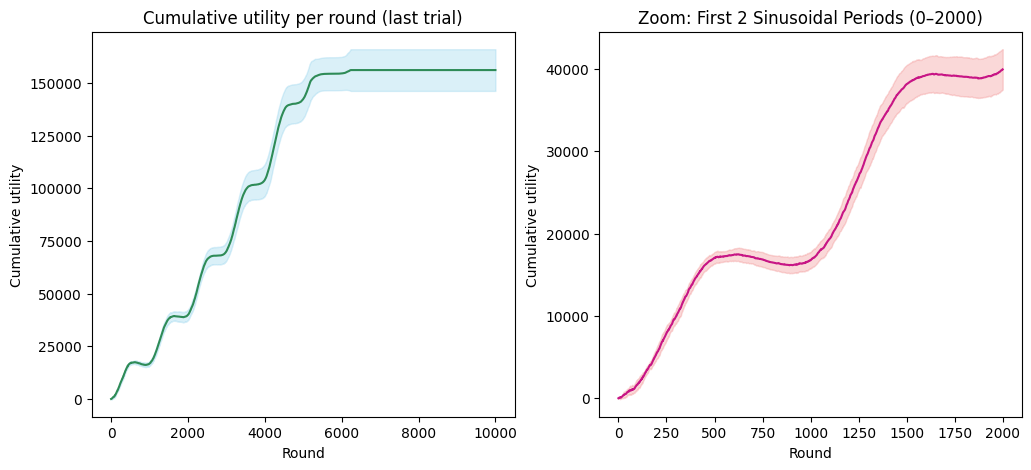

In [18]:
plt.figure(figsize=(12, 5))

# --- Full cumulative utility plot ---
plt.subplot(1, 2, 1)
plt.plot(mean_cum_util, color='seagreen', label='Cumulative utility')
plt.fill_between(np.arange(T), mean_cum_util - std_cum_util, mean_cum_util + std_cum_util, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
plt.title('Cumulative utility per round (last trial)')

# --- Zoomed plot for first two periods ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(zoom_end), mean_cum_util[:zoom_end], color='mediumvioletred', label='Zoomed view (first 2 periods)')
plt.fill_between(np.arange(zoom_end), mean_cum_util[:zoom_end] - std_cum_util[:zoom_end], mean_cum_util[:zoom_end] + std_cum_util[:zoom_end], color='lightcoral', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
_ = plt.title(f'Zoom: First {2} Sinusoidal Periods (0–{zoom_end})')

(0.0, 2000.0)

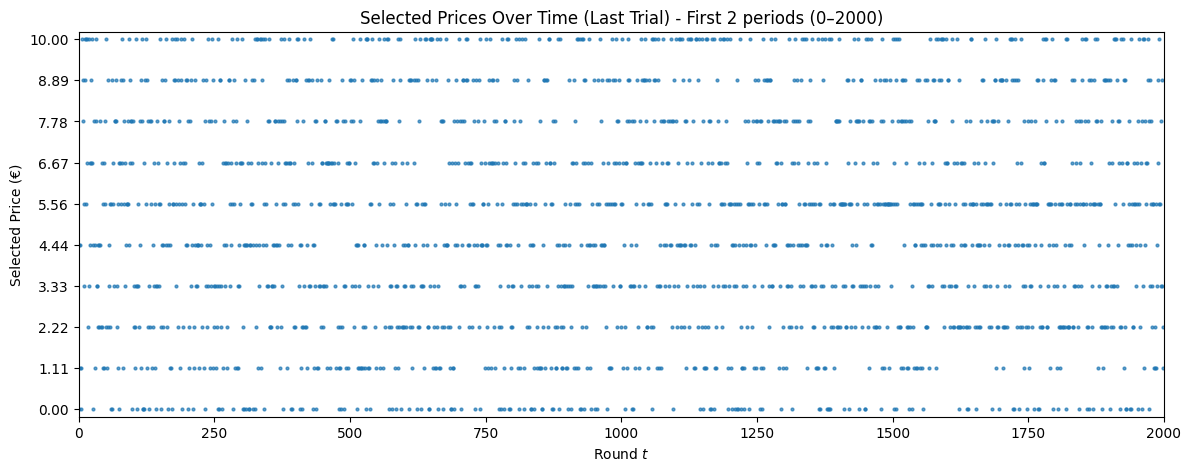

In [19]:
# After your last trial loop, get the chosen prices history
actions_in_time = agent.history_chosen_prices  # List of prices chosen at each round

# Prepare x-axis rounds
rounds_last = np.arange(len(actions_in_time))

plt.figure(figsize=(14, 5))
plt.plot(rounds_last[:zoom_end], actions_in_time[:zoom_end], '.', markersize=4, alpha=0.7)
plt.yticks(P)
plt.title(f"Selected Prices Over Time (Last Trial) - First 2 periods (0–{zoom_end})")
plt.xlabel("Round $t$")
plt.ylabel("Selected Price (€)")
plt.ylim(min(actions_in_time[:zoom_end]) - 0.2, max(actions_in_time[:zoom_end]) + 0.2)
plt.xlim(0, zoom_end)

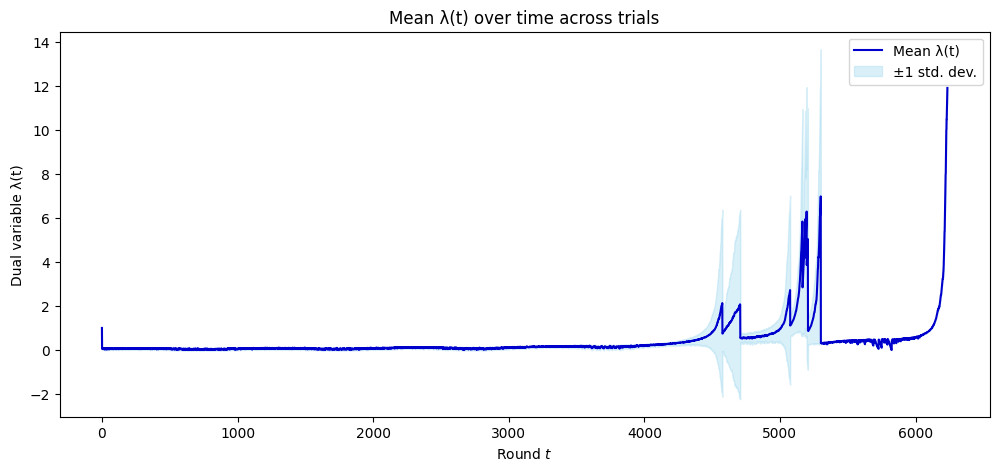

In [62]:
# How important was our constraint during the rounds?
rounds = np.arange(len(mean_lambda))

plt.figure(figsize=(12, 5))
plt.plot(rounds, mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(rounds, mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title('Mean λ(t) over time across trials')
_ = plt.legend()

### Plotting rho vs number of sales per round

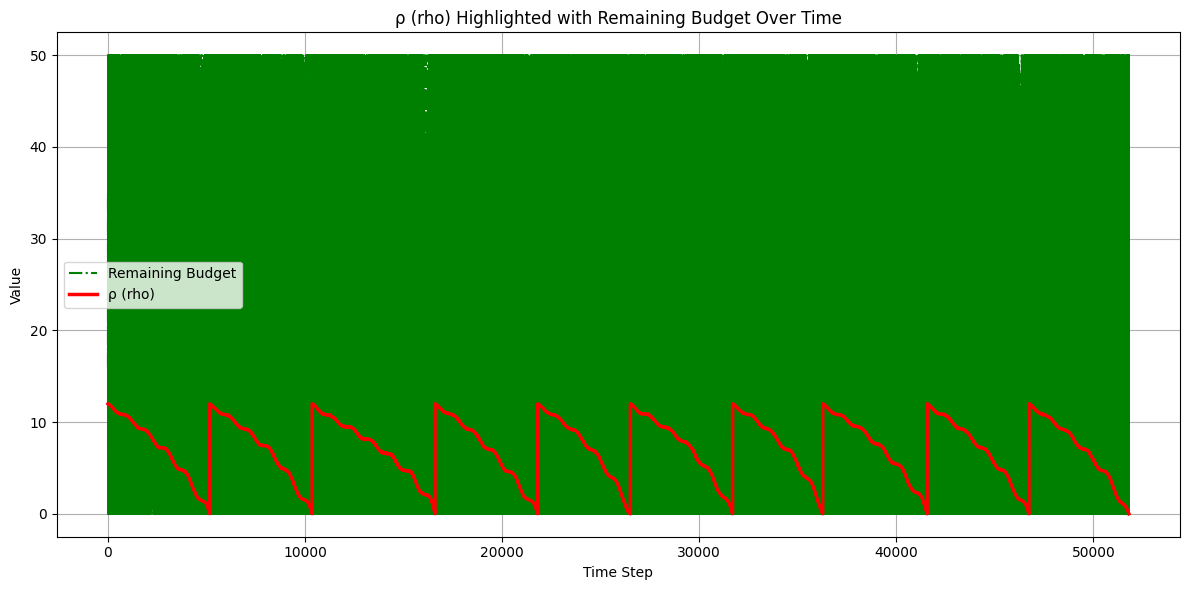

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assumiamo che all_rho, B_over_t e all_remaining_budget abbiano la stessa lunghezza
time_steps = np.arange(len(all_rho))

plt.figure(figsize=(12, 6))

# Plot dei pezzi venduti (vendite cumulative o budget rimanente)
plt.plot(time_steps, all_sold_pieces, label='Sold pieces', color='green', linestyle='-.')

# (Facoltativo) Plot di B/t, se vuoi reinserirlo:
# plt.plot(time_steps, B_over_t, label='B / t', color='gray', linestyle='--')

# Plot di rho in primo piano
plt.plot(time_steps, all_rho, label='ρ (rho)', color='red', linewidth=2.5)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('ρ (rho) Highlighted with sold pieces Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Zoom in

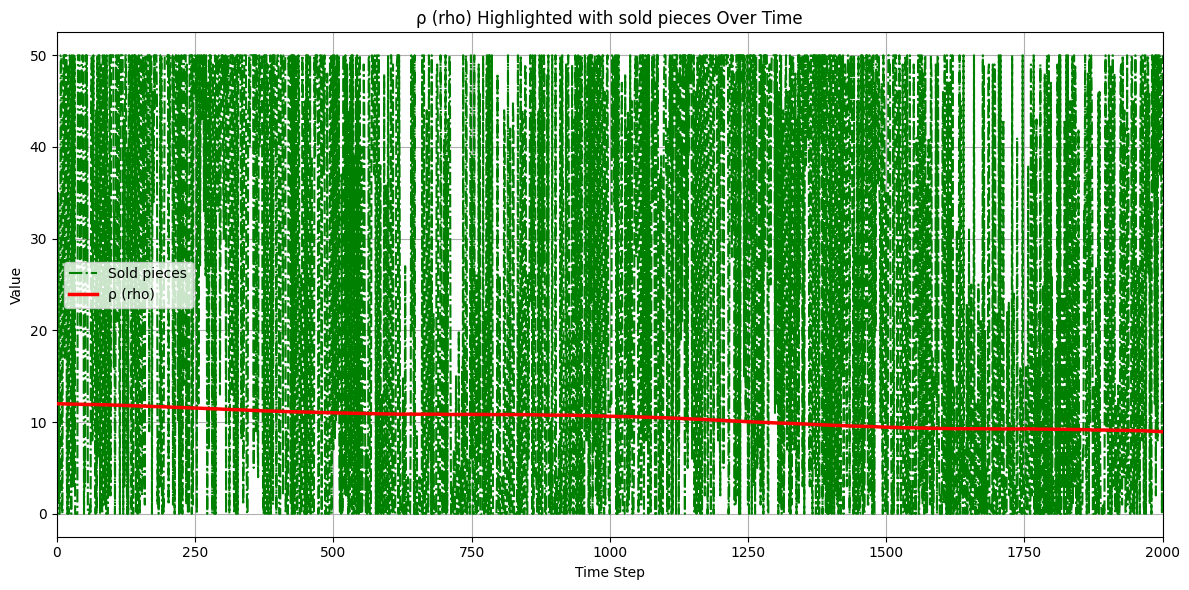

In [56]:

# Assumiamo che all_rho e all_remaining_budgets abbiano la stessa lunghezza
time_steps = np.arange(len(all_rho))

plt.figure(figsize=(12, 6))

# Plot del budget rimanente
plt.plot(time_steps, all_sold_pieces, label='Sold pieces', color='green', linestyle='-.')

# Plot di rho in evidenza
plt.plot(time_steps, all_rho, label='ρ (rho)', color='red', linewidth=2.5, zorder=3)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('ρ (rho) Highlighted with sold pieces Over Time')
plt.legend()
plt.grid(True)
plt.xlim(0, 2000)  # Zoom sulla finestra desiderata
plt.tight_layout()
plt.show()


### Plotting lambda vs Number of sales per round vs rho

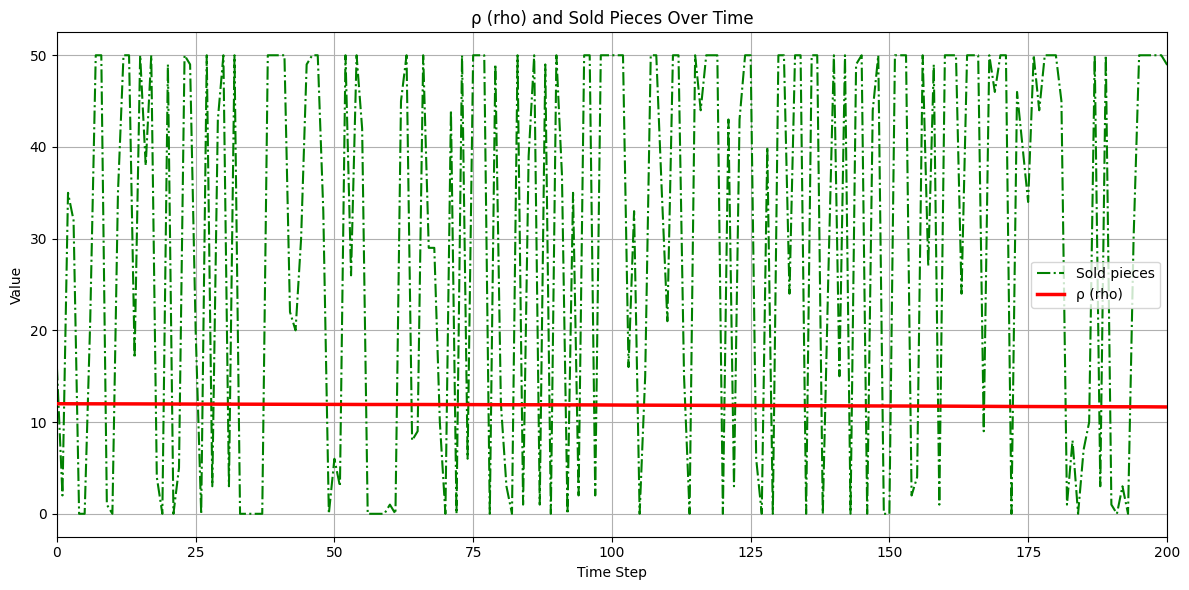

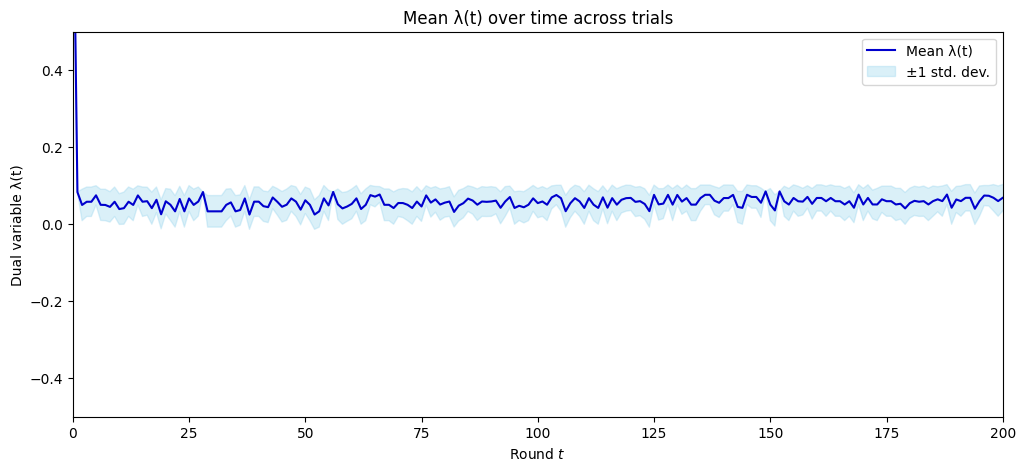

In [66]:
import matplotlib.pyplot as plt
import numpy as np

time_steps = np.arange(len(all_rho))

# Primo plot: rho e pezzi venduti
plt.figure(figsize=(12, 6))
plt.plot(time_steps, all_sold_pieces, label='Sold pieces', color='green', linestyle='-.')
plt.plot(time_steps, all_rho, label='ρ (rho)', color='red', linewidth=2.5, zorder=3)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('ρ (rho) and Sold Pieces Over Time')
plt.legend()
plt.grid(True)
plt.xlim(0, 200)  # Zoom
plt.tight_layout()
plt.show()

# Secondo plot: lambda
# How important was our constraint during the rounds?
rounds = np.arange(len(mean_lambda))

plt.figure(figsize=(12, 5))
plt.plot(rounds, mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(rounds, mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.ylim((-0.5,0.5))
plt.title('Mean λ(t) over time across trials')
plt.xlim(0, 200)  # Zoom
_ = plt.legend()


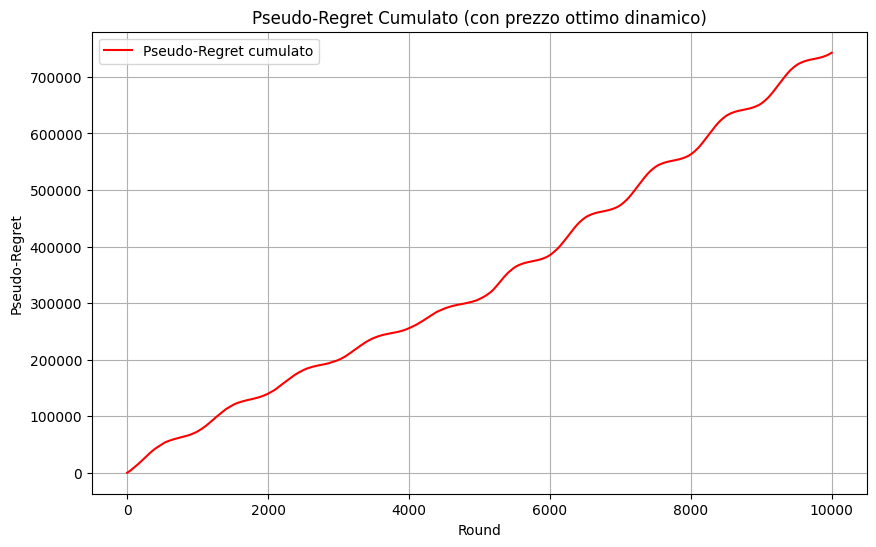

In [24]:
# Per ogni round calcoliamo il mean valuation in quel round
mean_valuations = env.initial_base_mean_valuation + env.amplitude * np.sin(2 * np.pi * np.arange(T) / env.period)

# Per ogni round calcoliamo il miglior reward possibile (miglior prezzo che massimizza la funzione obiettivo)
optimal_rewards_per_round = np.zeros(T)
for t in range(T):
    mu_t = mean_valuations[t]
    best_reward_t = -np.inf
    for p in P:
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        expected_reward = (p - cost) * expected_sales
        if expected_reward > best_reward_t:
            best_reward_t = expected_reward
    optimal_rewards_per_round[t] = best_reward_t

# Cumuliamo il reward ottimale (dinamico)
optimal_cum_reward = np.cumsum(optimal_rewards_per_round)

# Reward cumulato medio dell’agente
mean_cum_agent_reward = np.mean(all_rewards, axis=0)

# Pseudo-regret cumulato
pseudo_regret = optimal_cum_reward - mean_cum_agent_reward

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pseudo_regret, label='Pseudo-Regret cumulato', color='red')
plt.title('Pseudo-Regret Cumulato (con prezzo ottimo dinamico)')
plt.xlabel('Round')
plt.ylabel('Pseudo-Regret')
plt.grid(True)
plt.legend()
plt.show()


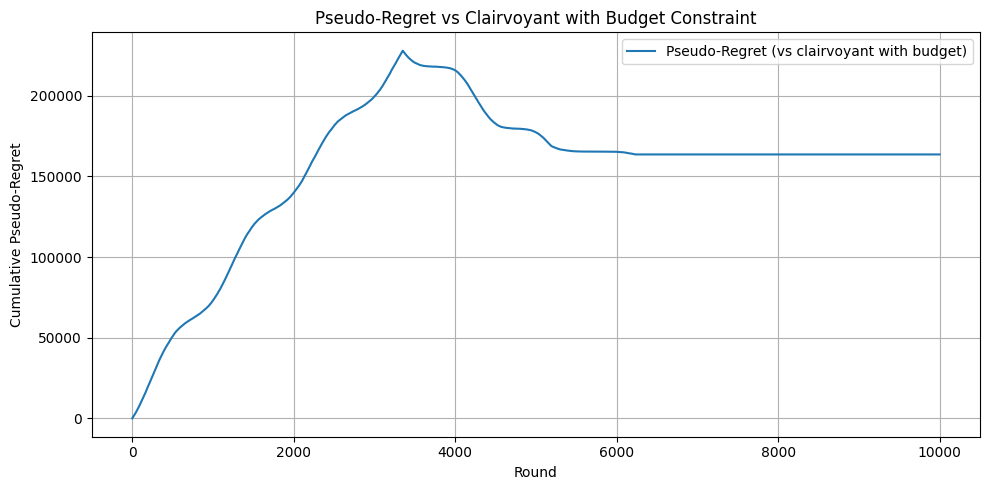

In [26]:
# Valutazioni medie sinusoidali nei T round
mean_valuations = initial_value + amplitude * np.sin(2 * np.pi * np.arange(T) / period)

# Simulazione clairvoyant con budget limitato
remaining_budget_clairvoyant = B
clairvoyant_cum_rewards = []
cum_reward = 0

for t in range(T):
    if remaining_budget_clairvoyant <= 0:
        clairvoyant_cum_rewards.extend([cum_reward] * (T - t))
        break

    mu_t = mean_valuations[t]

    best_reward_t = -np.inf
    best_price_t = None
    best_expected_sales_t = 0

    for p in P:
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        expected_reward = (p - cost) * expected_sales
        if expected_reward > best_reward_t:
            best_reward_t = expected_reward
            best_price_t = p
            best_expected_sales_t = expected_sales

    sales_t = min(best_expected_sales_t, remaining_budget_clairvoyant)
    reward_t = (best_price_t - cost) * sales_t
    cum_reward += reward_t
    clairvoyant_cum_rewards.append(cum_reward)
    remaining_budget_clairvoyant -= sales_t

clairvoyant_cum_rewards = np.array(clairvoyant_cum_rewards)

# Pseudo-regret: clairvoyant budget - agente
pseudo_regret_budget = clairvoyant_cum_rewards - mean_cum_util

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pseudo_regret_budget, label='Pseudo-Regret (vs clairvoyant with budget)')
plt.xlabel("Round")
plt.ylabel("Cumulative Pseudo-Regret")
plt.title("Pseudo-Regret vs Clairvoyant with Budget Constraint")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Now with drifting increasing environment

In [87]:
# --- Simulation ---
all_rewards = []  # Store per-trial reward trajectories

for seed in range(n_trials):
    
    # Set up environment
    np.random.seed(seed)
    env = PricingEnvironmentSingleProductDriftingMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, drift_rate=drift_rate)

    # Initialize agent
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=max(P) / K, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None)
    
    rewards = np.zeros(T)
    for t in range(T):
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        cont = agent.update(idx, sales, reward)
        rewards[t] = reward
        if not cont:
            rewards[t+1:] = 0
            break

    all_rewards.append(np.cumsum(rewards))      # Store cumulative rewards

# --- Analysis and Plotting ---
all_rewards = np.array(all_rewards)             # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

Terminated at round 3842 due to budget.
Terminated at round 3913 due to budget.
Terminated at round 4359 due to budget.
Terminated at round 3787 due to budget.
Terminated at round 3741 due to budget.
Terminated at round 4011 due to budget.
Terminated at round 3748 due to budget.
Terminated at round 3961 due to budget.
Terminated at round 3880 due to budget.
Terminated at round 3924 due to budget.


### Plot

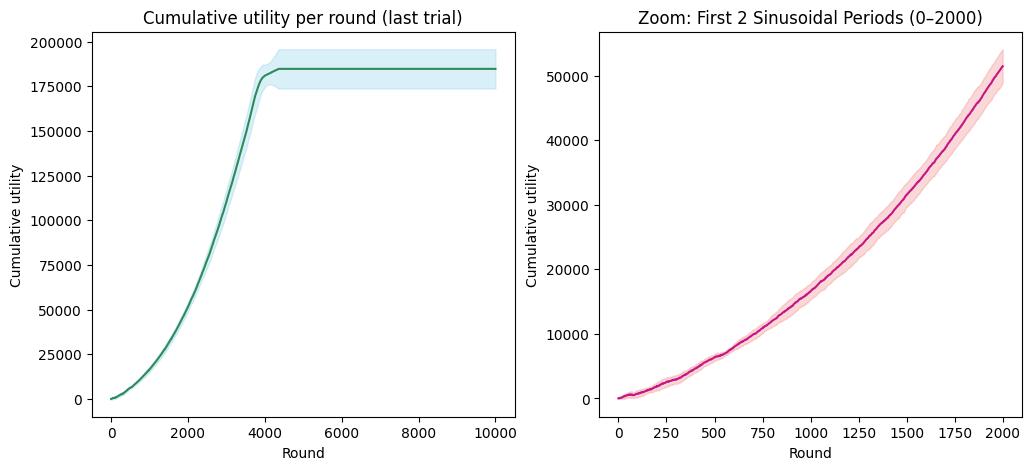

In [88]:
plt.figure(figsize=(12, 5))

# --- Full cumulative utility plot ---
plt.subplot(1, 2, 1)
plt.plot(mean_cum_util, color='seagreen', label='Cumulative utility')
plt.fill_between(np.arange(T), mean_cum_util - std_cum_util, mean_cum_util + std_cum_util, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
plt.title('Cumulative utility per round (last trial)')

# --- Zoomed plot for first two periods ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(zoom_end), mean_cum_util[:zoom_end], color='mediumvioletred', label='Zoomed view (first 2 periods)')
plt.fill_between(np.arange(zoom_end), mean_cum_util[:zoom_end] - std_cum_util[:zoom_end], mean_cum_util[:zoom_end] + std_cum_util[:zoom_end], color='lightcoral', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
_ = plt.title(f'Zoom: First {2} Sinusoidal Periods (0–{zoom_end})')

### Now with drifting decreasing environment

In [89]:
# --- Simulation ---
all_rewards = []  # Store per-trial reward trajectories

for seed in range(n_trials):
    
    # Set up environment
    np.random.seed(seed)
    env = PricingEnvironmentSingleProductDriftingMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, drift_rate=-drift_rate)

    # Initialize agent
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=max(P) / K, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None)
    
    rewards = np.zeros(T)
    for t in range(T):
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        cont = agent.update(idx, sales, reward)
        rewards[t] = reward
        if not cont:
            rewards[t+1:] = 0
            break

    all_rewards.append(np.cumsum(rewards))      # Store cumulative rewards

# --- Analysis and Plotting ---
all_rewards = np.array(all_rewards)             # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

### Plot

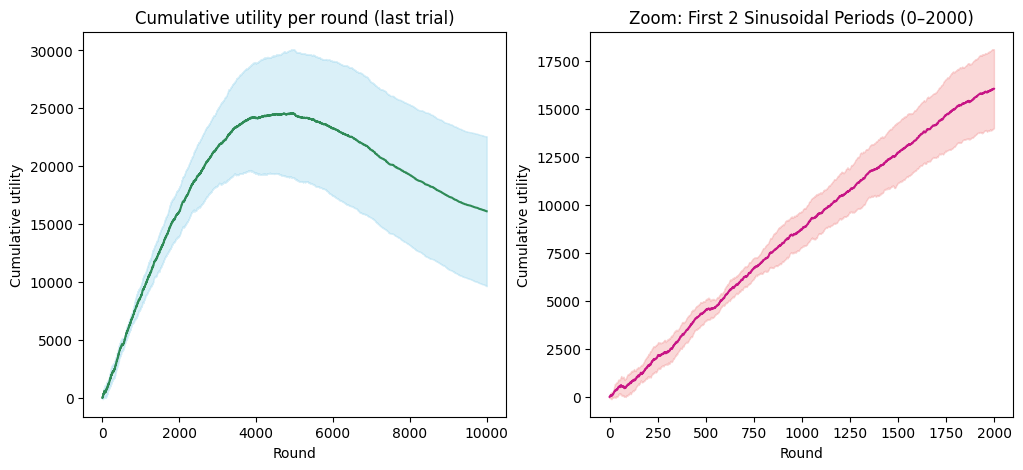

In [90]:
plt.figure(figsize=(12, 5))

# --- Full cumulative utility plot ---
plt.subplot(1, 2, 1)
plt.plot(mean_cum_util, color='seagreen', label='Cumulative utility')
plt.fill_between(np.arange(T), mean_cum_util - std_cum_util, mean_cum_util + std_cum_util, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
plt.title('Cumulative utility per round (last trial)')

# --- Zoomed plot for first two periods ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(zoom_end), mean_cum_util[:zoom_end], color='mediumvioletred', label='Zoomed view (first 2 periods)')
plt.fill_between(np.arange(zoom_end), mean_cum_util[:zoom_end] - std_cum_util[:zoom_end], mean_cum_util[:zoom_end] + std_cum_util[:zoom_end], color='lightcoral', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
_ = plt.title(f'Zoom: First {2} Sinusoidal Periods (0–{zoom_end})')